# Preamble 
L'objectif de ce document est de présenter un algorithme de détermination de l'angle d'une remorque à l'arrière d'un véhicule équipé d'une caméra vidéo.


# import
Le programme écrit en python s'appuie sur plusieurs bibliothèques existantes standard.

In [1]:
import cv2
print(cv2.__version__)
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi
import pandas as pd
import os
from numba import jit

4.1.0


# File selection

In [2]:
path = "/Users/oliviermanette/Desktop/trailer detection challenge/data/P473_Arizona_Day_Asphalt_Close_To_Sunset_dry_Nominal_8300lx"
os.chdir(path)

In [3]:
pwd

'/Users/oliviermanette/Desktop/trailer detection challenge/data/P473_Arizona_Day_Asphalt_Close_To_Sunset_dry_Nominal_8300lx'

In [4]:
ls

P473_Arizona_Day_Asphalt_Close_To_Sunset_dry_Nominal_8300lx.avi*
P473_Arizona_Day_Asphalt_Close_To_Sunset_dry_Nominal_8300lx.dat_GT.csv*


In [5]:
#fileName='W420_ES_Hi_Snow_Slush_Asphalt_28klux.avi'
fileName = 'P473_Arizona_Day_Asphalt_Close_To_Sunset_dry_Nominal_8300lx.avi'

# Test Video Loop

In [6]:
cap = cv2.VideoCapture(fileName)  # load the video
while (cap.isOpened()):  # play the video by reading frame by frame
    ret, frame = cap.read()
    if ret == True:
        # optional: do some image processing here
        cv2.imshow('frame', frame)
        # show the video
        if cv2.waitKey(1) & 0xFF == ord('q'):
            #if 0xFF == ord('q'):
            break
    else:
        break
cap.release()
cv2.destroyAllWindows()

# Variables globales
Pour des raisons de lisibilité du code, l'ensemble des variables locales seront précédés du préfixe 'l' afin de les différencier des variables globales qui n'ont pas de préfixe.
## Type de données de position

In [7]:
posType = np.dtype([('x', 'u1'), ('y', 'u2')])

## Type de données de Neurones

In [8]:
NeuronType = np.dtype([('longueur', 'u1'), ('angle', 'f4'), ('weight', 'f4'),
                       ('precision', 'f4'), ('xPos', 'u1'), ('yPos', 'u2'),
                       ('group', 'u1'), ('layer', 'u1')])

## Taille des champs récepteurs neuronaux

In [9]:
tailleField = 7

# Fonctions
## Calcul d'un neurone champ moyen
A partir d'une liste de neurones, il retourne le neurone moyen

In [10]:
def getAvgFieldNeuron(lNeuronList, typeList=NeuronType):
    lNeurons = np.zeros(1, dtype=typeList)
    lpNeurons = pd.DataFrame(lNeurons)
    lpNeurons['longueur'] = int(lNeuronList.longueur[0:1])
    lpNeurons['angle'] = float(
        np.sum((lNeuronList.angle * lNeuronList.weight) /
               np.sum(lNeuronList.weight)))
    lpNeurons['weight'] = float(
        np.sum((lNeuronList.weight * lNeuronList.weight) /
               np.sum(lNeuronList.weight)))
    lpNeurons['precision'] = float(
        np.sum((lNeuronList.precision * lNeuronList.weight) /
               np.sum(lNeuronList.weight)))
    lpNeurons['xPos'] = np.around(
        np.sum((lNeuronList.xPos * lNeuronList.weight)) /
               np.sum(lNeuronList.weight))
    lpNeurons['yPos'] = np.around(
        np.sum((lNeuronList.yPos * lNeuronList.weight)) /
               np.sum(lNeuronList.weight))
    return lpNeurons

## Matrice des directions
Afin de faciliter le calcul des angles des pixels, une matrice de poids est générée afin d'appliquer à chaque pixel centré sur un champs récepteur un poids correspondant à l'angle d'une ligne passant par ce centre.
Voici comment les angles sont représentés <br> <b>IMAGE</b>

In [11]:
@jit(nopython=True, parallel=True)
def fillAngleMat(lSize):
    lOutput = np.zeros((lSize, lSize))
    lOffset = int(np.floor(lSize / 2))
    for lX in range(0, lSize):
        for lY in range(0, lSize):
            if (lX - lOffset) == 0:
                lOutput[lX, lY] = 90
            else:
                lOutput[lX, lY] = 0.01 + np.around(
                    np.arctan((lY - lOffset) / (lOffset - lX)) / pi * 180, 2)
    lOutput[lOffset, lOffset] = 0
    return lOutput

## Fonction d'activation des neurones
Chaque neurone retourne une valeur comprise entre 0 et 255 qui reflète son niveau d'activation. Cette activation reflète le niveau de confiance que le neurone a sur le lien existant entre sa fonction de base et les pixels reçus dans son champs récepteur. Plus les pixels sont organisés de façon à former une ligne avec l'angle correspondant à la fonction de base du neurone et plus ce dernier sera activé. Comme on ne souhaite pas obtenir une activation de valeur infinie, on utilise donc une fonction sigmoide qui s'applique à l'écart-type des angles supposés. 

In [12]:
@jit(nopython=True, parallel=True)
def sigmoidActivationFctN1(lActivationVector):
    lDenom = (1 + np.exp(0.1 * (np.abs(np.std(lActivationVector)) - 30)))
    return 255 / lDenom

## Création d'une liste de neurones à champs récepteurs

In [13]:
#@jit(nopython=True, parallel=True)
def getNeuronActivationList(idxX, idxY, size, frameE, nbPixelPts, layer=1, lVerbose=False):
    #commencer par créer le tableau de neurones
    lNeuronType = np.dtype([('longueur', 'u1'), ('angle', 'f4'),
                            ('weight', 'f4'), ('precision', 'f4'),
                            ('xPos', 'u1'), ('yPos', 'u2'), ('group', 'u1')])
    lCriterion = nbPixelPts >= size

    nbNeurons = sum(lCriterion)
    lNeurons = np.zeros(nbNeurons, dtype=lNeuronType)
    lpNeurons = pd.DataFrame(lNeurons)
    lpNeurons['longueur'] = size
    lpNeurons['layer'] = layer

    offsetField = int(np.floor(size / 2))
    lAngleMat = fillAngleMat(size)

    newX = idxX[lCriterion]
    newY = idxY[lCriterion]
    if lVerbose:
        print("size :" + str(len(newX)))

        print("newX")
        print(np.min(newX))
        print(np.max(newX))
        print("newY")
        print(np.min(newY))
        print(np.max(newY))
        print()
    pos = 0
    lnPos = 0
    for lintX in newX:
        lintY = newY[pos]
        if (lintX - offsetField)<0 or (lintY - offsetField)<0:
            print("exceed the limit of the matrix")
            pos += 1
            continue
        
        lNeuronFieldFrame = frameE[
            int(lintX - offsetField):int(lintX + offsetField + 1),
            int(lintY - offsetField):int(lintY + offsetField + 1)] / 255

        try:
            tmp = np.multiply(lAngleMat, lNeuronFieldFrame)
        except:
            print("error 10 : ")
            print("lAngleMat")
            print(lAngleMat)
            print("lNeuronFieldFrame")
            print(lNeuronFieldFrame)
            print("lintX")
            print(lintX)
            print("lintY")
            print(lintY)
            print("offsetField")
            print(offsetField)
            continue

        lNeuronFieldValues = tmp[np.nonzero(tmp)]
        if (lNeuronFieldValues.size > 0):
            lpNeurons.loc[pos, ['angle']] = np.mean(lNeuronFieldValues)
            lpNeurons.loc[pos, ['weight']] = sigmoidActivationFctN1(
                lNeuronFieldValues)
            lpNeurons.loc[pos, ['precision']] = np.std(lNeuronFieldValues)
            lpNeurons.loc[pos, ['xPos']] = lintX
            lpNeurons.loc[pos, ['yPos']] = lintY

            lnPos += 1
        else:
            True  #print ("error it shouldn't be zero")
        pos += 1
    if lVerbose:
        print("nb de positions couvertes : " + str(lnPos) + " sur " + str(pos))

    return lpNeurons

## Nombre de pixels actifs dans chaque champs récepteur
A partir des coordonnées des centres supposés de chaque champs récepteurs et de la taille du champs récepteur, recherche sur la frame bitmap passée en paramètres, retourne un tableau contenant le nombre de pixels allumés à l'intérieur de chacun de ces champs.

In [14]:
@jit(nopython=True, parallel=True)
def nbPixelField(lTableX, lTableY, lFrameEdge, lintTailleField=3):
    lIdx = 0
    lResults = np.zeros(lTableX.size)
    lRayon = np.floor(lintTailleField / 2)
    lTailleMaxX = lFrameEdge.shape[0]
    #lTailleMaxY = lFrameEdge.shape[1]
    lHalfX = lTailleMaxX / 3

    for lPosX in lTableX:
        lPosY = lTableY[lIdx]
        if lPosX > lHalfX and lPosX >= lRayon and (lPosX +
                                                   lRayon) < lTailleMaxX:
            lResults[lIdx] = np.sum(
                lFrameEdge[int(lPosX - lRayon):int(lPosX + lRayon + 1),
                           int(lPosY - lRayon):int(lPosY + lRayon + 1)] / 255)
        lIdx += 1
    return lResults

In [15]:
#@jit(nopython=True, parallel=True)
def getNonZero(LImg):
    return np.where(LImg != [0])

## Coordonnées de la fonction de base (ligne)

In [16]:
def getNFCoordinate(lNeurone):
    try:
        lintDist = int(np.floor(lNeurone.longueur / 2))
    except:
        lP1 = (0, 0)
        lP2 = (0, 0)
        return (lP1, lP2)
    if np.abs(lNeurone.angle) < 45:
        lAlpha = lNeurone.angle / 180 * pi
        lintX1 = np.around(lNeurone.xPos - lintDist * np.tan(lAlpha))
        lintY1 = lNeurone.yPos + lintDist
        lintX2 = np.around(lNeurone.xPos + lintDist * np.tan(lAlpha))
        lintY2 = lNeurone.yPos - lintDist
    else:
        lAlpha = (90 - lNeurone.angle) / 180 * pi
        #print("yPos = "+str(lNeurone.yPos)+"xPos = "+str(lNeurone.xPos))
        lintY1 = np.around(lNeurone.yPos - lintDist * np.tan(lAlpha))
        lintX1 = lNeurone.xPos - lintDist
        lintY2 = np.around(lNeurone.yPos + lintDist * np.tan(lAlpha))
        lintX2 = lNeurone.xPos + lintDist
    lP1 = (int(lintY1), int(lintX1))
    lP2 = (int(lintY2), int(lintX2))
    return lP1, lP2

In [17]:
np.tan(0)

0.0

## Calcule la distance entre deux points

In [18]:
def getDistance(lx1, ly1, lx2, ly2):
    return np.sqrt(
        np.power(np.abs(lx1 - lx2), 2) + np.power(np.abs(ly1 - ly2), 2))

## Retourne les neurones les plus proches d'un point

In [19]:
def closestFieldNeurons(lneuronList, lposX, lposY, ldistance):

    return lneuronList[(lneuronList.xPos >= lposX - ldistance)
                       & (lneuronList.xPos <= lposX + ldistance) &
                       (lneuronList.yPos >= lposY - ldistance) &
                       (lneuronList.yPos <= lposY + ldistance)]

## Dessine les fonctions de base des neurones sur un bitmap

In [20]:
def drawFieldNeurons(lNeuronList, lBitmap, lVerbose=False):
    for index, lNeuron in lNeuronList.iterrows():
        #for lNeuron in lNeuronList:
        lCoord = getNFCoordinate(lNeuron)
        if lVerbose:
            print(lNeuron)
            print(lCoord)
        try:
            cv2.line(lBitmap, lCoord[0], lCoord[1], (int(
                lNeuron.weight), int(lNeuron.weight), int(lNeuron.weight)), 1)
        except:
            True
    return lBitmap

## Find neuronal groups
Un groupe neuronal est un ensemble de neurone dont les champs récepteurs sont complémentaires les uns des autres. Pour faire  partie d'un champs récepteur, deux conditions doivent être réunies.
<b>(A compléter)</b>
### Translation
Retourne les coordonnées d'un point translaté d'une certaine distance avec un certain angle. Cette fonction demande un angle, une distance et les coordonnées d'un point de départ. Il retourne ensuite les coordonnées après translation.

In [21]:
#@jit(nopython=True, parallel=True)
def moveCoordDeg(langle, lstartX, lstartY, ldistance, lVerbose=False):
    if lVerbose:
        ##DEBUG
        print("* moveCoordDeg(" + str(float(langle)) + "," +
              str(int(lstartX)) + "," + str(int(lstartY)) +
              "," + str(int(ldistance))+")")
        ##DEBUG
    ltipX = lstartX + ldistance * np.cos(langle / 180 * pi)
    ltipY = lstartY - ldistance * np.sin(langle / 180 * pi)
    if lVerbose:
        print ("* coord ==> ("+str(ltipX)+","+str(ltipY))
    return ltipX, ltipY

Effectue le même calcul que la fonction <i>moveCoordDeg </i>  mais prend comme paramètre un neurone. Il effectue la translation en prenant comme point de départ le centre du champs récepteur et effectue un déplacement de la taille de ce champs dans la direction de la fonction de base. 

In [22]:
def getNextPosition(lneuroneMoyen, lVerbose): 
    return moveCoordDeg(float(lneuroneMoyen.angle), int(lneuroneMoyen.xPos),
                        int(lneuroneMoyen.yPos), int(lneuroneMoyen.longueur), lVerbose)

### Calcul des  groupes à partir d'une liste de neurones à champs récepteurs

In [23]:
def findGroups(lneuronList, lVerbose=False):
    # Sélection d'un nouveau numéro de Groupe (GroupID)
    lintCurrentGroupID = 0
    lintNbGroups = 0
    lIndex = 0

    ##DEBUG
    lnbNeuron = 0
    ##DEBUG
    # liste des neurones sans groupe
    lNoGroupList = lneuronList[lneuronList.group == 0]

    while lNoGroupList.shape[0] > 0:

        #Sélection d'un neurone dans la liste (ceux sans groupID ou groupID=0)
        lMoyenNeuron = lNoGroupList.iloc[0]
        lIndex = lNoGroupList.head().index.values[0]

        while True:
            #Assignation d'un nouveau numéro de GroupID en cours
            lintNbGroups += 1
            lintCurrentGroupID += 1
            if lneuronList[lneuronList.group ==
                           lintCurrentGroupID].shape[0] == 0:
                break

        lneuronList.loc[lIndex, ['group']] = lintCurrentGroupID

        #déplacement
        lnPos = getNextPosition(lMoyenNeuron, lVerbose)

        #recherche de neurones proches
        lClosestNeurons = closestFieldNeurons(
            lneuronList, lnPos[0], lnPos[1],
            int(np.floor(lMoyenNeuron.longueur / 2)))
        if lVerbose:
            print("")
            print("")
            print("Coordonnées en cours : (" + str(lnPos[0]) + "," +
                  str(lnPos[1]) + ")")

            lnbNeuron += 1
            if lClosestNeurons.shape[0] == 0:
                print("Aucun neurone a proximité pour le neurone #" +
                      str(lnbNeuron) + " aux coordonnées : (" + str(lnPos[0]) +
                      "," + str(lnPos[1]) + str(") a la distance :") +
                      str(int(np.floor(lMoyenNeuron.longueur / 2))))

            #Oui ==> retour étape 1
            lNbFindGroup = 0

        while lClosestNeurons.shape[0] != 0:
            #recherche des groupID dans cette sous-sélection
            if lClosestNeurons[lClosestNeurons.group > 0].shape[0] == 0:
                #Non => Assigner à tous les neurones de la sous-sélection
                #le groupID en cours => aller directement à l'étape 7
                if lVerbose:
                    print("Aucun neurone dans le groupe : " +
                          str(lintCurrentGroupID))

                for lintIdx in lClosestNeurons.head().index.values:
                    lneuronList.loc[lintIdx, ['group']] = lintCurrentGroupID
            else:
                #Oui
                if lVerbose:
                    ##DEBUG
                    #lNbFindGroup += 1
                    print("Trouvé " + str(lClosestNeurons[
                        lClosestNeurons.group > 0].shape[0]) +
                          " neurone(s) déja dans des groupes :")
                    print("Groupe en cours : " + str(lintCurrentGroupID))

                #Récupération de la liste de tous les groupID utilisés
                #Sélection du groupID le plus petit
                #(en comparant aussi avec le groupID en cours)
                lintPreviousGroupID = lintCurrentGroupID
                lintCurrentGroupID = np.min(
                    lClosestNeurons[lClosestNeurons.group > 0].group)
                if lVerbose:
                    print("Change pour le groupe #" + str(lintCurrentGroupID))
                    print("-")
                #Assigner au neurone en cours le nouveau groupe
                lneuronList.loc[lIndex, ['group']] = lintCurrentGroupID
                #Assigner à tous les neurones de la sous-sélection ce nouveau groupID
                for lintIdx in lClosestNeurons.head().index.values:
                    lneuronList.loc[lintIdx, ['group']] = lintCurrentGroupID
                    #remplacer dans la liste globale,
                    #pour chaque groupID présent dans la liste par le nouveau groupID
                    for lintGroupID in lClosestNeurons[
                            lClosestNeurons.group > 0].group:
                        lneuronList.loc[lneuronList.group == lintGroupID,
                                        'group'] = lintCurrentGroupID
                if lintPreviousGroupID == lintCurrentGroupID:
                    #si tous les neurones
                    if lClosestNeurons[lClosestNeurons.group >
                                       0].shape[0] == lClosestNeurons[
                                           lClosestNeurons.group ==
                                           lintPreviousGroupID].shape[0]:
                        break  # sortie de la boucle while
            if lVerbose:
                #Calcul du neurone Field moyen
                print("Neurones trouvé :")
                print(lClosestNeurons)
            lMoyenNeuron = getAvgFieldNeuron(lClosestNeurons)
            if lVerbose:
                print("neurone Moyen")
                print(lMoyenNeuron)
            #déplacement
            lnPos = getNextPosition(lMoyenNeuron, lVerbose)

            #recherche de neurones proches
            lClosestNeurons = closestFieldNeurons(
                lneuronList, lnPos[0], lnPos[1],
                int(np.floor(lMoyenNeuron.longueur / 2)))

        lNoGroupList = lneuronList[lneuronList.group == 0]
    return lneuronList

# Video Loop

In [24]:
kernelSize = 21  # Kernel Bluring size

# Edge Detection Parameter
parameter1 = 20
parameter2 = 40
intApertureSize = 1

#cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture(fileName)
lCounter = 0
while (cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        # Our operations on the frame come here
        if lCounter == 1:
            frame = cv2.GaussianBlur(frame, (kernelSize, kernelSize), 0, 0)
            frame = cv2.Canny(frame, parameter1, parameter2,
                              intApertureSize)  # Canny edge detection
            lCounter = 0
        lCounter += 1

        indices = np.where(frame != [0])
        # Display the resulting frame
        cv2.imshow('Edges Video', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):  # press q to quit
            break
    else:
        break
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

# Sandbox
## Toy data Generator

In [25]:
def generateToy(lType=1, lHauteur=80, lLargeur=128,lepaisseur=1):
    lFrame = 0
    if lType == 1:
        lFrame = np.zeros((lHauteur, lLargeur))
        lFrame[:, int((lLargeur-lepaisseur) / 2):int((lLargeur+lepaisseur) / 2)] = 255
    elif lType == 2:
        lFrame = np.zeros((lHauteur, lLargeur))
        lFrame[int((lHauteur-lepaisseur) / 2):int((lHauteur+lepaisseur)/2), :] = 255
    elif lType == 3:
        lFrame = np.zeros((lHauteur, lLargeur))
        cv2.line(lFrame, (int(lLargeur / 3), lHauteur),
                 (int(2 * lLargeur / 3), 0), (255, 255, 255), lepaisseur)
    elif lType == 4:
        lFrame = np.zeros((lHauteur, lLargeur))
        cv2.rectangle(lFrame,
                      (int(lLargeur / 128 * 10), int(lHauteur / 80 * 30)),
                      (int(lLargeur / 128 * 30), int(lHauteur / 80 * 50)),
                      (255, 255, 255), lepaisseur)
        pts = np.array([[int(lLargeur / 128 *64),
                         int(lHauteur / 80 * 30)],
                        [int(lLargeur / 128 * 76),
                         int(lHauteur / 80 * 50)],
                        [int(lLargeur / 128 * 53),
                         int(lHauteur / 80 *50)]], np.int32)
        ts = pts.reshape((-1, 1, 2))
        cv2.polylines(lFrame, [pts], True, (255, 255, 255), lepaisseur)
        cv2.circle(lFrame,
                   (int(lLargeur / 128 * 107), int(lHauteur / 80 * 40)),
                   int(lHauteur / 80 * 10), (255, 255, 255), lepaisseur)
    else:
        lFrame = np.zeros((lHauteur, lLargeur))
        print("First parameter should be between 1 to 4")
    return lFrame

## Playground
### Test 1
#### Generate data of type 1

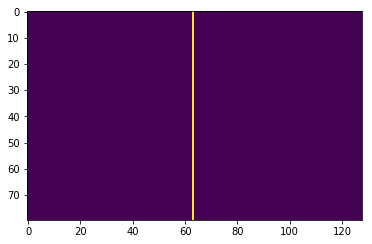

In [26]:
frame = generateToy(1,80,128,1)
imgplot = plt.imshow(frame)

#### Génération des neurones à champs récepteur

In [27]:
indices = np.where(frame != [0])
nbPixelsAll = nbPixelField(indices[0], indices[1], frame, tailleField)
titi = getNeuronActivationList(indices[0], indices[1], tailleField, frame,
                               nbPixelsAll)

In [28]:
titi.describe()

,longueur,angle,weight,precision,xPos,yPos,group,layer
count,50.0,5.000000e+01,50.000000,50.0,50.00000,50.0,50.0,50.0
mean,7.0,9.999996e-03,242.906311,0.0,51.50000,63.0,0.0,1.0
std,0.0,3.763112e-09,0.000092,0.0,14.57738,0.0,0.0,0.0
min,7.0,1.000000e-02,242.906403,0.0,27.00000,63.0,0.0,1.0
25%,7.0,1.000000e-02,242.906403,0.0,39.25000,63.0,0.0,1.0
50%,7.0,1.000000e-02,242.906403,0.0,51.50000,63.0,0.0,1.0
75%,7.0,1.000000e-02,242.906403,0.0,63.75000,63.0,0.0,1.0
max,7.0,1.000000e-02,242.906403,0.0,76.00000,63.0,0.0,1.0


In [29]:
titi[0:4]

,longueur,angle,weight,precision,xPos,yPos,group,layer
0,7,0.01,242.906403,0.0,27,63,0,1
1,7,0.01,242.906403,0.0,28,63,0,1
2,7,0.01,242.906403,0.0,29,63,0,1
3,7,0.01,242.906403,0.0,30,63,0,1


#### Affichage graphique du champs récepteur des neurones

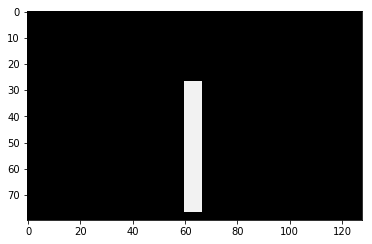

In [30]:
testBitmap = np.zeros((frame.shape[0],frame.shape[1],3), np.uint8)
testBitmap = drawFieldNeurons(titi, testBitmap)
imgplot = plt.imshow(testBitmap)

In [31]:
np.max(testBitmap)

242

In [32]:
lintI = 0
while (lintI < 10):
    cv2.imshow('FRAME', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):  # press q to quit
        break
    lintI += 1

#### Génération des groupes

In [33]:
findGroups(titi);

In [34]:
titi.groupby('group').agg(['mean', 'count'])[0:5]

longueur       angle            weight       precision        xPos  \
          mean count  mean count        mean count      mean count  mean   
group                                                                      
1            7    50  0.01    50  242.906403    50       0.0    50  51.5   

            yPos       layer        
      count mean count  mean count  
group                               
1        50   63    50     1    50

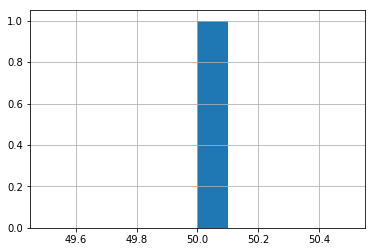

In [35]:
titi.groupby('group').size().hist()

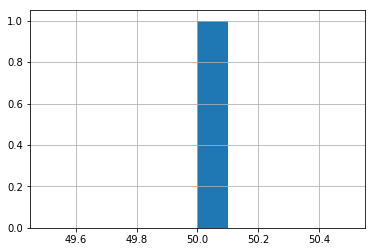

In [36]:
resultGroup = titi.groupby('group').size()
resultGroup[resultGroup>10].hist()

In [37]:
titi.describe()

,longueur,angle,weight,precision,xPos,yPos,group,layer
count,50.0,5.000000e+01,50.000000,50.0,50.00000,50.0,50.0,50.0
mean,7.0,9.999996e-03,242.906311,0.0,51.50000,63.0,1.0,1.0
std,0.0,3.763112e-09,0.000092,0.0,14.57738,0.0,0.0,0.0
min,7.0,1.000000e-02,242.906403,0.0,27.00000,63.0,1.0,1.0
25%,7.0,1.000000e-02,242.906403,0.0,39.25000,63.0,1.0,1.0
50%,7.0,1.000000e-02,242.906403,0.0,51.50000,63.0,1.0,1.0
75%,7.0,1.000000e-02,242.906403,0.0,63.75000,63.0,1.0,1.0
max,7.0,1.000000e-02,242.906403,0.0,76.00000,63.0,1.0,1.0


In [38]:
titi[0:4]

,longueur,angle,weight,precision,xPos,yPos,group,layer
0,7,0.01,242.906403,0.0,27,63,1,1
1,7,0.01,242.906403,0.0,28,63,1,1
2,7,0.01,242.906403,0.0,29,63,1,1
3,7,0.01,242.906403,0.0,30,63,1,1


### Test 2
#### Generate data of type 2

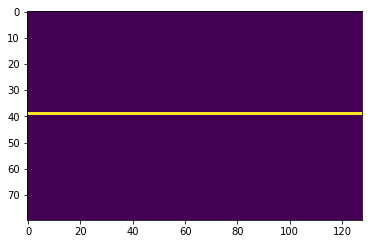

In [39]:
frame = generateToy(2,80,128,1)
imgplot = plt.imshow(frame)

#### Génération des neurones à champs récepteur

In [40]:
indices = np.where(frame != [0])
nbPixelsAll = nbPixelField(indices[0], indices[1], frame, tailleField)
titi = getNeuronActivationList(indices[0], indices[1], tailleField, frame,
                               nbPixelsAll)

exceed the limit of the matrix
exceed the limit of the matrix
exceed the limit of the matrix
error 10 : 
lAngleMat
[[-4.499e+01 -3.368e+01 -1.842e+01  1.000e-02  1.844e+01  3.370e+01
   4.501e+01]
 [-5.630e+01 -4.499e+01 -2.656e+01  1.000e-02  2.658e+01  4.501e+01
   5.632e+01]
 [-7.156e+01 -6.342e+01 -4.499e+01  1.000e-02  4.501e+01  6.344e+01
   7.158e+01]
 [ 9.000e+01  9.000e+01  9.000e+01  0.000e+00  9.000e+01  9.000e+01
   9.000e+01]
 [ 7.158e+01  6.344e+01  4.501e+01  1.000e-02 -4.499e+01 -6.342e+01
  -7.156e+01]
 [ 5.632e+01  4.501e+01  2.658e+01  1.000e-02 -2.656e+01 -4.499e+01
  -5.630e+01]
 [ 4.501e+01  3.370e+01  1.844e+01  1.000e-02 -1.842e+01 -3.368e+01
  -4.499e+01]]
lNeuronFieldFrame
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
lintX
39
lintY
125
offsetField
3
error 10 : 
lAngleMat
[[-4.499e+01 -3.368e+01 -1.842e+01  1.000e-02  1.844e+01  3.370e+01
   4.501e+01]
 [-5.63

In [41]:
titi.describe()

,longueur,angle,weight,precision,xPos,yPos,group,layer
count,128.0,128.000000,128.000000,128.0,128.000000,128.000000,128.0,128.0
mean,7.0,85.781250,231.520050,0.0,37.171875,60.523438,0.0,1.0
std,0.0,19.098122,51.545200,0.0,8.275863,37.053901,0.0,0.0
min,7.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1.0
25%,7.0,90.000000,242.906403,0.0,39.000000,28.750000,0.0,1.0
50%,7.0,90.000000,242.906403,0.0,39.000000,60.500000,0.0,1.0
75%,7.0,90.000000,242.906403,0.0,39.000000,92.250000,0.0,1.0
max,7.0,90.000000,242.906403,0.0,39.000000,124.000000,0.0,1.0


In [42]:
titi[0:4]

,longueur,angle,weight,precision,xPos,yPos,group,layer
0,7,0.0,0.000000,0.0,0,0,0,1
1,7,0.0,0.000000,0.0,0,0,0,1
2,7,0.0,0.000000,0.0,0,0,0,1
3,7,90.0,242.906403,0.0,39,3,0,1


#### Affichage graphique du champs récepteur des neurones

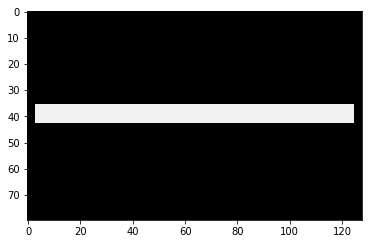

In [43]:
testBitmap = np.zeros((frame.shape[0],frame.shape[1],3), np.uint8)
testBitmap = drawFieldNeurons(titi, testBitmap)
imgplot = plt.imshow(testBitmap)

#### Génération des groupes

In [44]:
findGroups(titi);

In [45]:
titi.groupby('group').agg(['mean', 'count'])[0:5]

longueur       angle            weight       precision       xPos        \
          mean count  mean count        mean count      mean count mean count   
group                                                                           
1            7     1   0.0     1    0.000000     1       0.0     1    0     1   
2            7     1   0.0     1    0.000000     1       0.0     1    0     1   
3            7     1   0.0     1    0.000000     1       0.0     1    0     1   
4            7   122  90.0   122  242.906403   122       0.0   122   39   122   
5            7     1   0.0     1    0.000000     1       0.0     1    0     1   

       yPos       layer        
       mean count  mean count  
group                          
1       0.0     1     1     1  
2       0.0     1     1     1  
3       0.0     1     1     1  
4      63.5   122     1   122  
5       0.0     1     1     1

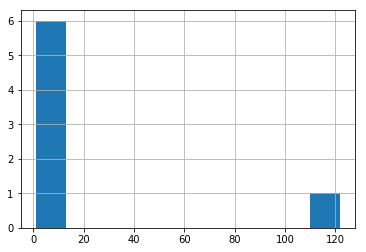

In [46]:
titi.groupby('group').size().hist()

In [47]:
titi[0:4]

,longueur,angle,weight,precision,xPos,yPos,group,layer
0,7,0.0,0.000000,0.0,0,0,1,1
1,7,0.0,0.000000,0.0,0,0,2,1
2,7,0.0,0.000000,0.0,0,0,3,1
3,7,90.0,242.906403,0.0,39,3,4,1


### Test 3
#### Generate data of type 3

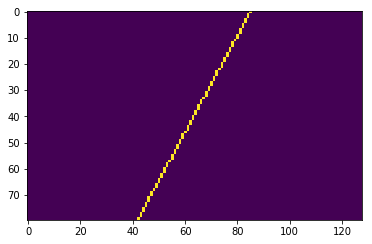

In [48]:
frame = generateToy(3,80,128,1)
imgplot = plt.imshow(frame)

#### Génération des neurones à champs récepteur

In [58]:
indices = np.where(frame != [0])
nbPixelsAll = nbPixelField(indices[0], indices[1], frame, tailleField)
titi = getNeuronActivationList(indices[0], indices[1], tailleField, frame,
                               nbPixelsAll)

In [50]:
titi.describe()

,longueur,angle,weight,precision,xPos,yPos,group,layer
count,50.0,50.000000,50.000000,50.000000,50.00000,50.000000,50.0,50.0
mean,7.0,26.755207,213.043991,13.634507,51.50000,56.980000,0.0,1.0
std,0.0,2.806284,5.832972,1.934354,14.57738,7.924362,0.0,0.0
min,7.0,25.053333,205.570328,7.588554,27.00000,44.000000,0.0,1.0
25%,7.0,25.053333,212.746216,13.835940,39.25000,50.250000,0.0,1.0
50%,7.0,25.053333,212.746216,13.835940,51.50000,57.000000,0.0,1.0
75%,7.0,27.596666,212.746216,13.835940,63.75000,63.750000,0.0,1.0
max,7.0,35.096668,230.490402,15.747627,76.00000,70.000000,0.0,1.0


In [51]:
titi[0:4]

,longueur,angle,weight,precision,xPos,yPos,group,layer
0,7,25.053333,212.746216,13.83594,27,70,0,1
1,7,25.053333,212.746216,13.83594,28,70,0,1
2,7,25.053333,212.746216,13.83594,29,69,0,1
3,7,25.053333,212.746216,13.83594,30,69,0,1


#### Affichage graphique du champs récepteur des neurones

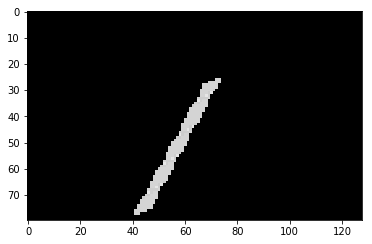

In [52]:
testBitmap = np.zeros((frame.shape[0],frame.shape[1],3), np.uint8)
testBitmap = drawFieldNeurons(titi, testBitmap)
imgplot = plt.imshow(testBitmap)

#### Génération des groupes

In [59]:
findGroups(titi);

In [60]:
titi.groupby('group').agg(['mean', 'count'])[0:5]

longueur            angle            weight        precision        \
          mean count       mean count        mean count       mean count   
group                                                                      
1            7    50  26.755199    50  213.044052    50  13.634507    50   

       xPos         yPos       layer        
       mean count   mean count  mean count  
group                                       
1      51.5    50  56.98    50     1    50

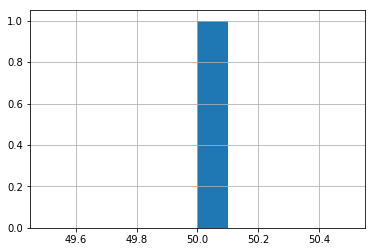

In [61]:
titi.groupby('group').size().hist()

### Test 4
#### Generate data of type 4

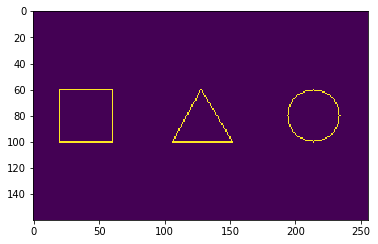

In [62]:
frame = generateToy(4,160,256,1)
imgplot = plt.imshow(frame)

#### Génération des neurones à champs récepteur

In [64]:
indices = np.where(frame != [0])
nbPixelsAll = nbPixelField(indices[0], indices[1], frame, tailleField)
titi = getNeuronActivationList(indices[0], indices[1], tailleField, frame,
                               nbPixelsAll)

In [65]:
titi.describe()

,longueur,angle,weight,precision,xPos,yPos,group,layer
count,398.0,398.000000,398.000000,398.000000,398.000000,398.000000,398.0,398.0
mean,7.0,31.615257,198.189850,13.808285,82.311558,117.037688,0.0,1.0
std,0.0,44.897732,71.696381,18.358315,15.140764,72.832620,0.0,0.0
min,7.0,-49.946667,3.008756,0.000000,60.000000,20.000000,0.0,1.0
25%,7.0,0.010000,203.268784,0.000000,67.000000,50.000000,0.0,1.0
50%,7.0,25.053333,230.490402,7.588554,84.000000,120.000000,0.0,1.0
75%,7.0,90.000000,242.906403,16.312169,99.000000,195.000000,0.0,1.0
max,7.0,90.000000,242.906403,74.278679,100.000000,234.000000,0.0,1.0


In [66]:
titi[0:4]

,longueur,angle,weight,precision,xPos,yPos,group,layer
0,7,45.005001,46.537529,44.994999,60,20,0,1
1,7,64.290001,123.892136,30.566092,60,21,0,1
2,7,74.018753,176.191147,21.954557,60,22,0,1
3,7,79.212219,202.501602,16.500349,60,23,0,1


#### Affichage graphique du champs récepteur des neurones

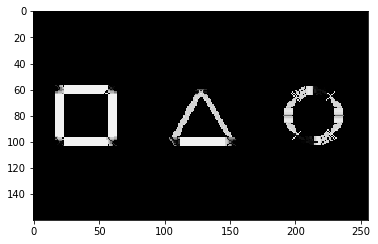

In [67]:
testBitmap = np.zeros((frame.shape[0],frame.shape[1],3), np.uint8)
testBitmap = drawFieldNeurons(titi, testBitmap)
imgplot = plt.imshow(testBitmap)

#### Génération des groupes

In [68]:
findGroups(titi);

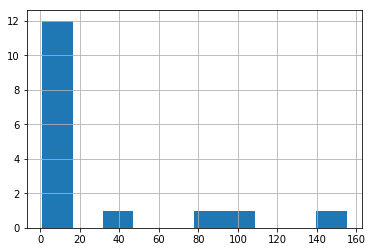

In [70]:
titi.groupby('group').size().hist()

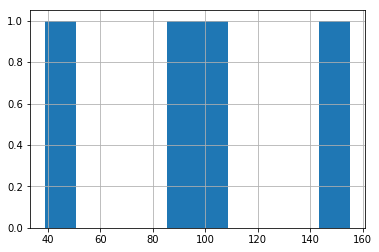

In [71]:
resultGroup = titi.groupby('group').size()
resultGroup[resultGroup>10].hist()

In [73]:
titi.groupby('group').agg(['mean', 'count'])[resultGroup>10]

longueur            angle            weight        precision        \
          mean count       mean count        mean count       mean count   
group                                                                      
1            7   155  42.931614   155  226.566147   155   4.614272   155   
6            7    86  53.976654    86  200.396561    86  13.244889    86   
9            7   106  16.978128   106  177.153824   106  21.094288   106   
16           7    39 -21.386602    39  191.786102    39  17.723696    39   

            xPos              yPos       layer        
            mean count        mean count  mean count  
group                                                 
1      80.638710   155   39.393548   155     1   155  
6      89.593023    86  122.779070    86     1    86  
9      80.716981   106  213.830189   106     1   106  
16     82.897436    39  141.666667    39     1    39

In [72]:
titi.describe()

,longueur,angle,weight,precision,xPos,yPos,group,layer
count,398.0,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.0
mean,7.0,31.615257,198.189850,13.808285,82.311558,117.037688,5.912060,1.0
std,0.0,44.897732,71.696381,18.358315,15.140764,72.832620,4.769741,0.0
min,7.0,-49.946667,3.008756,0.000000,60.000000,20.000000,1.000000,1.0
25%,7.0,0.010000,203.268784,0.000000,67.000000,50.000000,1.000000,1.0
50%,7.0,25.053333,230.490402,7.588554,84.000000,120.000000,6.000000,1.0
75%,7.0,90.000000,242.906403,16.312169,99.000000,195.000000,9.000000,1.0
max,7.0,90.000000,242.906403,74.278679,100.000000,234.000000,16.000000,1.0


# Errors list

## Error 10
Problème dans la fonction [getNeuronActivationList](#Création-d'une-liste-de-neurones-à-champs-récepteurs)


